**Problem Statement**

Earthquake monitoring and damage estimation is essential to ensure that necessary aid reaches the affected areas in atimely manner. However, the coverage of earthquake monitoring network is limited and inadequate for remote areas. Possible solution to this problem can be use of satellite imagery to estimate occurence of earthquake and also get a sense of the extent of damage.

This notebook presents a workflow to use the embeddings generated by Clay foundation model on Sentinel-1 data to predict whether earthquake has occurred or not. The code below provides a walkthrough of this binary classification problem (detecting earthquake) on Sentinel-1 imagery which is free and available through the Copernicus Sentinel program.

For more information on Sentinel-1 bands, please see https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD

**About the dataset**

*QuakeSet: A Dataset and Low-Resource Models to Monitor Earthquakes through Sentinel-1.*

Citation:
@misc{cambrin2024quakesetdatasetlowresourcemodels,
      title={QuakeSet: A Dataset and Low-Resource Models to Monitor Earthquakes through Sentinel-1}, 
      author={Daniele Rege Cambrin and Paolo Garza},
      year={2024},
      eprint={2403.18116},
      archivePrefix={arXiv},
      primaryClass={cs.CV},
      url={https://arxiv.org/abs/2403.18116}, 
}

Huggingface link: https://huggingface.co/datasets/DarthReca/quakeset

Github link: https://github.com/DarthReca/quakeset/

torchgeo link: https://torchgeo.readthedocs.io/en/latest/_modules/torchgeo/datasets/quakeset.html#QuakeSet

**Dataset Structure**

The dataset is divided into three folds with equal distribution of magnitudes and balanced in positive and negative examples.

<ins>Dataset features:</ins>

-Sentinel-1 SAR imagery

-before/pre/post imagery of areas affected by earthquakes

-2 SAR bands (VV/VH)

-3,327 pairs of pre and post images with 5 m per pixel resolution (512x512 px)

-2 classification labels (unaffected / affected by earthquake) (**used in this notebook for binary classification**)

-pre/post image pairs represent earthquake affected areas

-before/pre image pairs represent hard negative unaffected areas

-earthquake magnitudes for each sample

<ins>Dataset format:</ins>

single hdf5 dataset containing images, magnitudes, hypercenters, and splits

<ins>Dataset classes:</ins>

-unaffected area

-earthquake affected area


**Approaches to the problem**

Each sample consist of 2 images (vv and vh band) of pre-event and 2 images (vv and vh band) of post event and the image size is 512 x 512. The ground truth is 1 or 0 indicating whether earthquake has occurred or not. The binary classification problem can be solved using multiple approaches such as:

<ins>1. Using traditional machine learning </ins>
The images can be flattened such that each data point has dimension 512 x 512 x 4  with a label of 1 or 0. Then the data can be fed into a traditional ML model such as SVM or RF classifier directly or after the inputs has undergone dimensionality reduction through PCA / t-SNE etc.

<ins>2. Using deep learning </ins>
Deep learning algorithms such as CNN models can be trained on imagery treating the input to have 4 channels with labels being 1 or 0. Binary cross entropy loss functions can be used to optimize the CNN network

<ins>3. Using embeddings of pre-trained models</ins> 
Foundation models have revolutionalized the deep learning space wherein these models are pre-trained on large amount of data and are able to learn a lot of domain knowledge from the data itself. Recently, the application of these models have especially been visible in the NLP space (think LLMs and chatgpt). Clay is a foundation model for earth observation and the embeddings it generates on satellite data (of different platforms) can be used for multiple downstream tasks such as classification, regression etc. since the embeddings contain rich information about the imagery in a latent space. 

Our approach in this notebook is to use the Clay pre-trained model to generate embeddings on the Sentinel-1 imagery (of the Quakeset dataset) and use those embeddings as inputs to random forest classifier for binary classification. Our beleief is that since these embeddings already contain lots of information about the imagery, they should serve as useful features which can be used to do classification.

This approach is also computationally cheaper and faster since high end GPUs are not needed to train classifier models on embeddings and these models can be trained in few minutes. On the other hand, training large deep learning models require extensive hardware and long training times spanning days and sometime months.

**Using Clay embeddings to detect Earthquake - Code walkthrough**

In [1]:
# git clone https://github.com/Clay-foundation/model  #Need to run this for the first time

In [2]:
# pip install torchgeo[all]
# pip install git+https://github.com/microsoft/torchgeo.git   #Use this to be able to access the QuakeSet dataset

In [3]:
# importing the required modules

import torchgeo
import torchgeo.datasets as datasets
import sys
import torch
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import f1_score

sys.path.append("model/")

from src.model import ClayMAEModule

In [4]:
torchgeo.__version__  # check torchgeo version

'0.6.0.dev0'

**Downloading the QuakeSet dataset**

In [12]:
# We download the QuakeSet dataset available in torchgeo.

train_ds = datasets.QuakeSet(
    split="train", download=True
)  # Change download to True to download first time
val_ds = datasets.QuakeSet(split="val", download=True)
test_ds = datasets.QuakeSet(split="test", download=True)

100%|██████████| 9666460547/9666460547 [03:50<00:00, 41959334.33it/s]


In [13]:
# Checking the Sentinel-1 imagery size.

# Each sample consists of pre and post event data with two channels - vv and vh of Sentinel-1

train_ds[0]["image"].shape

torch.Size([4, 512, 512])

In [14]:
# Download Clay-1 model

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "https://clay-model-ckpt.s3.amazonaws.com/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path="model/configs/metadata.yaml", shuffle=False, mask_ratio=0
)
model.eval()

model = model.to(device)

Downloading: "https://clay-model-ckpt.s3.amazonaws.com/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt" to /teamspace/studios/this_studio/.cache/torch/hub/checkpoints/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt
100%|██████████| 1.61G/1.61G [01:49<00:00, 15.7MB/s]


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [15]:
# Dataset class to use for loading the data


class EarthQuakeDataset:
    def __init__(self, ds):
        self.ds = ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        pre_image = self.ds[idx]["image"][
            :2, :, :
        ]  # First two images are Sentinel-1 images (vv & vh band) of pre-event
        post_image = self.ds[idx]["image"][
            2:, :, :
        ]  # Last two images are Sentinel-1 images (vv & vh band) of post-event
        label = self.ds[idx]["label"]

        sample = {
            "pixels1": pre_image,  # 2 x 512 x 512
            "pixels2": post_image,  # 2 x 512 x 512
            "time": torch.zeros(4),  # Placeholder for time information
            "latlon": torch.zeros(4),  # Placeholder for latlon information
            "label": label,
        }

        return sample


# Construct training/validaton/test dataset object
train_dataset = EarthQuakeDataset(train_ds)
validation_dataset = EarthQuakeDataset(val_ds)
test_dataset = EarthQuakeDataset(test_ds)

In [16]:
# Dataloaders from dataset
BS = 8

train_dl = torch.utils.data.DataLoader(
    train_dataset, batch_size=BS, shuffle=True, generator=torch.Generator(device=device)
)
val_dl = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=BS,
    shuffle=False,
    generator=torch.Generator(device=device),
)
test_dl = torch.utils.data.DataLoader(
    test_dataset, batch_size=BS, shuffle=False, generator=torch.Generator(device=device)
)

In [17]:
# Generate embeddings for the data


def generate_and_save_embeddings(dl, split="train"):
    gsd = torch.tensor(10, device=device)  # Ground sampling distance for Sentinel-1
    waves = torch.tensor([3.5, 4.0], device=device)  # wavelengths for Sentinel-1

    embeddings1 = []
    embeddings2 = []
    target = []

    for bid, batch in enumerate(tqdm(dl)):
        datacube1 = {
            "pixels": batch["pixels1"].to(device),
            "time": batch["time"].to(device),
            "latlon": batch["latlon"].to(device),
            "gsd": gsd,
            "waves": waves,
        }

        datacube2 = {
            "pixels": batch["pixels2"].to(device),
            "time": batch["time"].to(device),
            "latlon": batch["latlon"].to(device),
            "gsd": gsd,
            "waves": waves,
        }

        with torch.no_grad():
            unmsk_patch1, unmsk_idx1, msk_idx1, msk_matrix1 = model.model.encoder(
                datacube1
            )
            unmsk_patch2, unmsk_idx2, msk_idx2, msk_matrix2 = model.model.encoder(
                datacube2
            )

        emb1 = unmsk_patch1[:, 0, :].cpu().numpy()
        emb2 = unmsk_patch2[:, 0, :].cpu().numpy()

        embeddings1.append(emb1)
        embeddings2.append(emb2)
        target.append(batch["label"].cpu().numpy())

    # Saving embeddings and ground truth (label) data
    np.save(
        f"{split}_emb.npy",
        np.concatenate(
            (np.concatenate(embeddings1), np.concatenate(embeddings2)), axis=1
        ),
    )
    np.save(f"{split}_label.npy", np.concatenate(target))

In [18]:
generate_and_save_embeddings(train_dl, "train")

  0%|          | 0/284 [00:00<?, ?it/s]

The time taken to generate embeddings on train data was ~48 minutes on 1 T4 GPU with batch size of 8. One can go faster if more powerful GPUs are available

In [19]:
generate_and_save_embeddings(val_dl, "val")

  0%|          | 0/69 [00:00<?, ?it/s]

In [20]:
generate_and_save_embeddings(test_dl, "test")

  0%|          | 0/64 [00:00<?, ?it/s]

In [29]:
# Load the saved embeddings and ground truth (labels)

train_fea = np.load("train_emb.npy")
train_label = np.load("train_label.npy")

train_fea.shape, train_label.shape

((2266, 1536), (2266,))

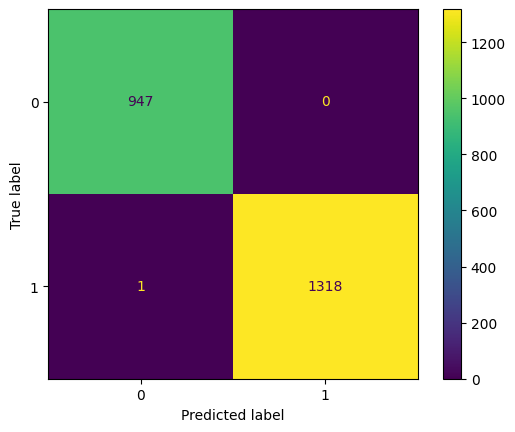

In [30]:
# Train a RandomForestClassifier on the embeddings

clf = xgb.XGBClassifier()  # Instantiate a RandomForestClassifier
clf.fit(train_fea, train_label)  # Train on embeddings

train_predictions = clf.predict(train_fea)  # Generate predictions on training set

# Confusion matrix
cm = confusion_matrix(train_label, train_predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [31]:
# check F1-score which is the metric for the competition which uses this data - "ECML-PKDD 2024 - SMAC: Seismic Monitoring and Analysis Challenge" https://www.codabench.org/competitions/2222/#/pages-tab had F1-score upward of 0.908 with training Deep Learning Models
trn_score = f1_score(train_label, train_predictions)

print("F1 score on training data: ", trn_score)

F1 score on training data:  0.9996207811907472


**Inspect the quality of predictions on Validation set**

In [32]:
# Load the saved embeddings and ground truth (labels)

val_fea = np.load("val_emb.npy")
val_label = np.load("val_label.npy")

val_fea.shape, val_label.shape

((550, 1536), (550,))

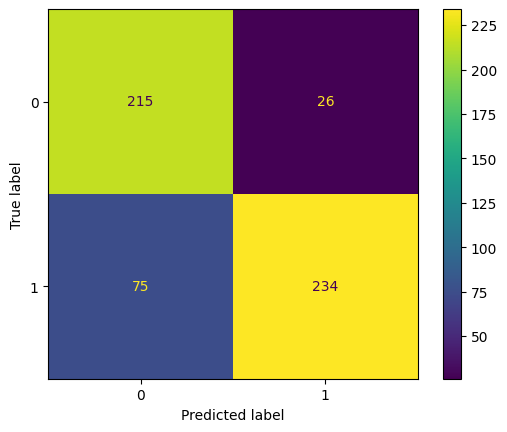

In [33]:
val_predictions = clf.predict(val_fea)  # Generate predictions on validation set

# Confusion matrix
cm = confusion_matrix(val_label, val_predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [34]:
# check F1-score which is the metric for the competition which uses this data - "ECML-PKDD 2024 - SMAC: Seismic Monitoring and Analysis Challenge" https://www.codabench.org/competitions/2222/#/pages-tab had F1-score upward of 0.908 with training Deep Learning Models

val_score = f1_score(val_label, val_predictions)

print("F1 score on validation data: ", val_score)

F1 score on validation data:  0.8224956063268892


**Inspect the quality of predictions on Test set**

In [35]:
# Load the saved embeddings and ground truth (labels)

test_fea = np.load("test_emb.npy")
test_label = np.load("test_label.npy")

test_fea.shape, test_label.shape

((511, 1536), (511,))

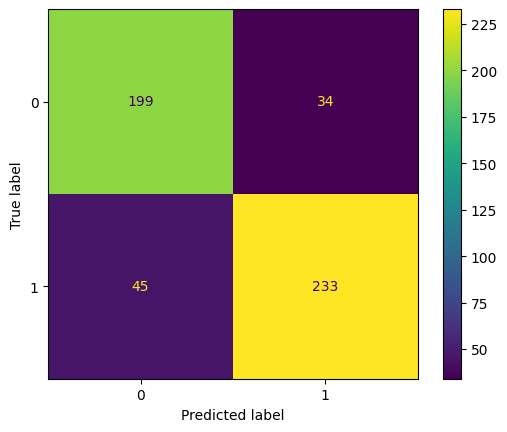

In [37]:
test_predictions = clf.predict(test_fea)  # Generate predictions on test set

# Confusion matrix
cm = confusion_matrix(test_label, test_predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [38]:
test_score = f1_score(test_label, test_predictions)

print("F1 score on validation data: ", test_score)

F1 score on validation data:  0.8550458715596331
